# Diffusion 101

This notebook contains codes to generated images using the DDPM, the standard method for diffusion models. We will generate images using a pretrained model that was trained on the CelebA dataset. The pretrained model can be found at: https://huggingface.co/google/ddpm-ema-celebahq-256

Install packages:

In [27]:
# !pip install diffusers

Import libraries:

In [28]:
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline
import matplotlib.pyplot as plt
import torch
import numpy as np

In [29]:
# Download model from huggingface
model_id = "google/ddpm-celebahq-256"
ddpm = DDPMPipeline.from_pretrained(model_id)  

# Are we using GPU and CPU?
device = "cuda:0" if torch.cuda.is_available() else "cpu"
ddpm = ddpm.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/harvey/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/harvey/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Noise Schedule

The noise scheduler describes how we combine our noise $\epsilon$ with our image $x_0$:

$$x_t=\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon$$

Our pretrained diffusion model uses a linear noise scheduler which is controlled by parameters $\beta=0.0001...0.02$:

$$\alpha_t=1-\beta_t$$
$$\bar{\alpha_t}=\prod_{s=1}^t{\alpha_s}$$


In [30]:
# Noise schedule parameters
timesteps = ddpm.scheduler.num_train_timesteps
beta_start = ddpm.scheduler.beta_start
beta_end = ddpm.scheduler.beta_end

# Noise schedule
betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

## Image Generation

To generate an image we start with pure Gaussian noise $x_T\sim\mathcal{N}(0,\boldsymbol{I})$. Using our diffusion we can then gradually move from to a clean image over $t$ timesteps:
$$x_T \rightarrow x_{T-1} \rightarrow ... \rightarrow x_{1} \rightarrow x_{0}$$
The function below will step through this chain. However, we can also skip steps for faster inference using the following formula which is implemented below:
$${x}_{t-1}=\sqrt{\bar{\alpha}_{t-1}} \left( \frac{{x}_t-\sqrt{1-\bar{\alpha}_t}D_{\theta}(x_t,t)}{\sqrt{\bar{\alpha}_t}} \right) + \sqrt{1-\bar{\alpha}_{t-1}} D_{\theta}(x_t,t)$$

where $D_{\theta}$ is our diffusion model and $t\in[0,T]$ is our timestep.


In [31]:
# Sampling
@torch.no_grad()
def sample(x_t, total_steps = 50):
    
    # Inference : Markov chain with T steps
    for i in reversed(range(0, timesteps, int(timesteps / total_steps))):

        # Get the correct shape for timesteps t
        t = torch.full((x_t.shape[0],), i, dtype=torch.long).to(device)

        # Run neural network
        predicted_noise = ddpm.unet(x_t, t).sample

        # Equation 12 - Denoising Diffusion Implicit Models (https://arxiv.org/pdf/2010.02502)
        alpha_cumprod = alphas_cumprod[t][:, None]
        alpha_cumprod_minus_1 = (torch.tensor(1.0) if i == 0 else alphas_cumprod[t-int(timesteps / total_steps)][:, None])
        
        # Select different timesteps
        predicted_image = (x_t - torch.sqrt(1 - alpha_cumprod) * predicted_noise) / torch.sqrt(alpha_cumprod)
        x_t = torch.sqrt(alpha_cumprod_minus_1) * predicted_image + torch.sqrt(1 - alpha_cumprod_minus_1) * predicted_noise

    return x_t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

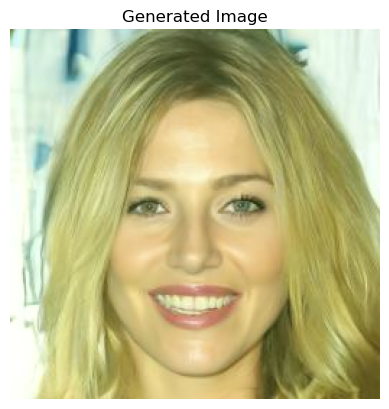

In [35]:
gen_image = sample(torch.randn(1,3,256,256).to(device), total_steps=100)
plt.imshow((np.transpose(gen_image[0].detach().cpu().numpy(), (1,2,0))+1)/2)
plt.title("Generated Image")
plt.axis('off')